In [1]:
import json, random
from pathlib import Path

import numpy as np
import torch

import os
os.chdir('..')
from utils.visualizer import SoccerVisualizer  # your class :contentReference[oaicite:1]{index=1}
from utils.static_maps import PitchStaticChannels

class MemmapShardCache:
    """
    Cache one shard in memory-mapped form.
    X: (N,C,H,W) float16
    T: (N,3)     float32
    """
    def __init__(self, out_root: str, split: str = "train", seed: int = 0):
        self.out_root = Path(out_root)
        self.split = split
        self.rng = random.Random(seed)

        split_dir = self.out_root / split
        manifest = json.loads((split_dir / "manifest.json").read_text())

        self.C = int(manifest["C"])
        self.H = int(manifest["H"])
        self.W = int(manifest["W"])
        self.channels = list(manifest["channels"])
        shards = list(manifest["shards"])
        if len(shards) == 0:
            raise RuntimeError(f"No shards in {split_dir}")

        shard = self.rng.choice(shards)
        self.N = int(shard["n"])

        x_path = split_dir / shard["x_path"]
        t_path = split_dir / shard["t_path"]

        self.X = np.memmap(x_path, mode="r", dtype=np.float16, shape=(self.N, self.C, self.H, self.W))
        self.T = np.memmap(t_path, mode="r", dtype=np.float32, shape=(self.N, 3))

        self.split_dir = split_dir
        self.shard_x_path = x_path

        print(f"[cache] split={split} shard={x_path.name} N={self.N} C={self.C} H={self.H} W={self.W}")

    def get(self, sample_idx: int | None = None):
        if sample_idx is None:
            sample_idx = self.rng.randrange(self.N)
        x_chw = torch.from_numpy(self.X[sample_idx].astype(np.float32, copy=False))  # (C,H,W)
        t_3 = torch.from_numpy(self.T[sample_idx].astype(np.float32, copy=False))   # (3,)
        return sample_idx, x_chw, t_3


## Show every channel

In [2]:
import math
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_all_channels_grid(
    viz,                      # SoccerVisualizer instance
    x_chw: torch.Tensor,      # (C,H,W)
    channels: list[str] | None = None,
    *,
    max_cols: int = 6,
    figsize_per_cell=(4.2, 3.0),
    plain: bool = True,
    cmap=None,
    add_colorbar: bool = False,
    suptitle: str | None = None,
):
    """
    Plot every channel of x_chw on its own pitch in one large figure.

    - Each subplot: one pitch + that channel as a heatmap
    - Uses viz.plot_heatmap(..., ax=...) so it's consistent with your visualizer.

    Returns: (fig, axes)
    """
    if not torch.is_tensor(x_chw):
        x_chw = torch.as_tensor(x_chw)

    if x_chw.dim() != 3:
        raise ValueError(f"x_chw must be (C,H,W), got {tuple(x_chw.shape)}")

    C, H, W = x_chw.shape
    if channels is None:
        channels = [f"ch_{i:02d}" for i in range(C)]
    else:
        if len(channels) != C:
            # Don't hard-fail — just fall back to indexing if mismatch
            channels = [f"{channels[i] if i < len(channels) else 'ch'}_{i:02d}" for i in range(C)]

    # Choose a grid
    ncols = min(max_cols, C)
    nrows = int(math.ceil(C / ncols))

    fig_w = figsize_per_cell[0] * ncols
    fig_h = figsize_per_cell[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
    axes = np.array(axes).reshape(nrows, ncols)

    # Draw each channel
    for i in range(nrows * ncols):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        if i >= C:
            ax.axis("off")
            continue

        heat = x_chw[i]  # (H,W)
        # viz expects (FL, FW) == (H,W) in its chosen layout; this matches your memmap.
        viz.plot_heatmap(
            heat,
            ax=ax,
            plain=plain,
            add_colorbar=add_colorbar,
        )
        ax.set_title(f"{i:02d}: {channels[i]}", fontsize=10)


    fig.tight_layout()
    return fig, axes


[cache] split=val shard=X_shard_0000.mmap N=7873 C=13 H=105 W=68


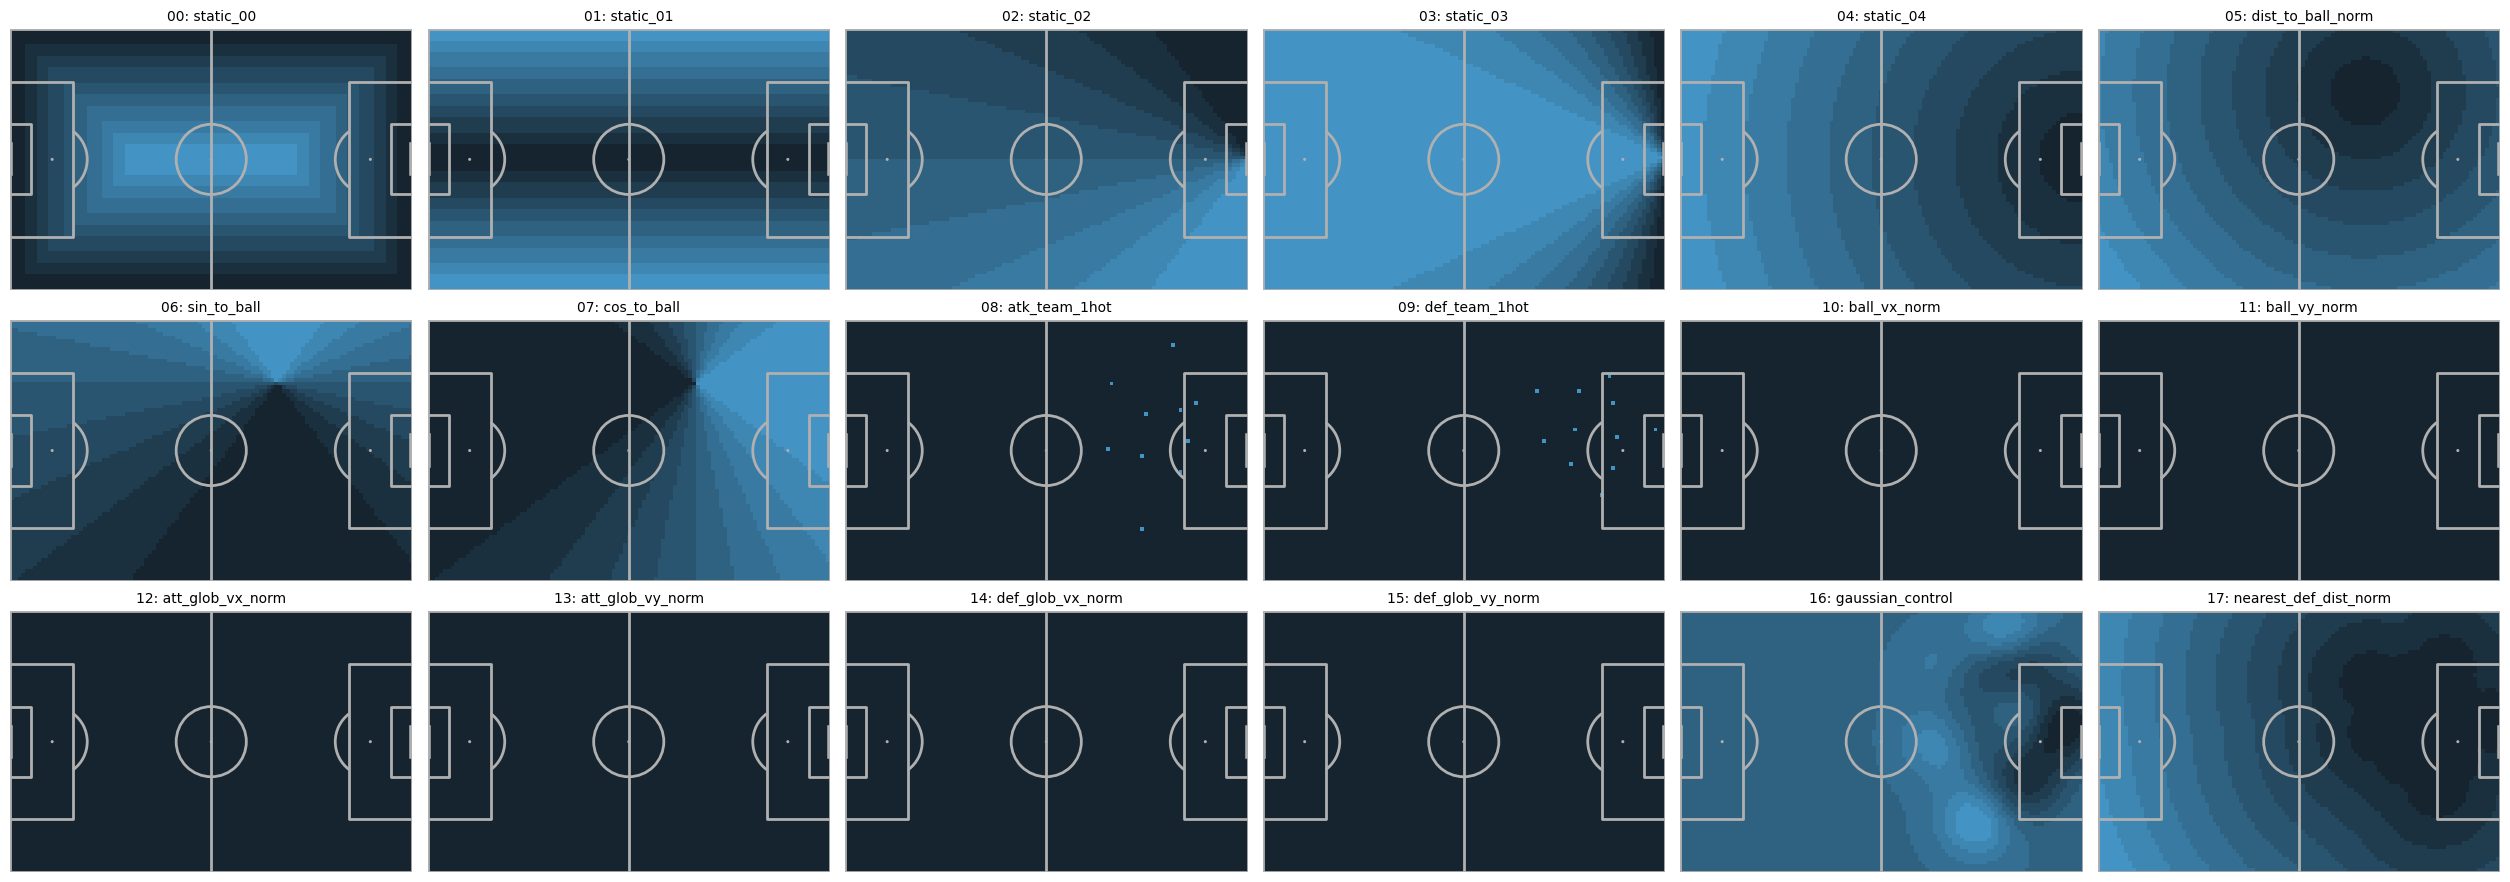

In [12]:
import torch

def append_static_channels(
    x_chw: torch.Tensor,                 # (C,H,W)
    dyn_channels: list[str],
    static: "PitchStaticChannels",
    *,
    H: int,
    W: int,
    device=None,
    dtype=torch.float32,
):
    """
    Returns:
      x2_chw: (C_static + C, H, W)
      channels2: static_names + dyn_channels

    This tries a few common method names on PitchStaticChannels to get:
      - static tensor (C_static,H,W)
      - static channel names
    """
    if not torch.is_tensor(x_chw):
        x_chw = torch.as_tensor(x_chw)
    x_chw = x_chw.to(dtype=dtype)
    if device is not None:
        x_chw = x_chw.to(device)

    # ---- get static tensor + names (try several likely APIs) ----
    static_x = None
    static_names = None

    # tensor creators
    for fn_name in ("get", "build", "make", "compute", "forward"):
        if hasattr(static, fn_name):
            fn = getattr(static, fn_name)
            try:
                out = fn(H, W)  # common signature
            except TypeError:
                try:
                    out = fn()   # maybe internally knows H,W
                except TypeError:
                    continue

            # out could be tensor or dict
            if torch.is_tensor(out):
                static_x = out
            elif isinstance(out, dict):
                # common patterns: {"X": tensor, "channels": [...]}
                if "X" in out and torch.is_tensor(out["X"]):
                    static_x = out["X"]
                if "channels" in out and isinstance(out["channels"], (list, tuple)):
                    static_names = list(out["channels"])
            break

    # names
    for attr in ("channels", "channel_names", "names"):
        if static_names is None and hasattr(static, attr):
            v = getattr(static, attr)
            if isinstance(v, (list, tuple)):
                static_names = list(v)

    if static_x is None:
        raise RuntimeError(
            "Couldn't obtain static channels from PitchStaticChannels. "
            "Expected a method like get/build/make/compute(H,W) returning (C,H,W)."
        )

    if not torch.is_tensor(static_x):
        static_x = torch.as_tensor(static_x)

    static_x = static_x.to(dtype=dtype)
    if device is not None:
        static_x = static_x.to(device)

    # ensure CHW
    if static_x.dim() == 2:
        static_x = static_x.unsqueeze(0)
    if static_x.dim() != 3:
        raise ValueError(f"static_x must be (C,H,W), got {tuple(static_x.shape)}")
    if static_x.shape[-2:] != (H, W):
        raise ValueError(f"static_x spatial shape {tuple(static_x.shape[-2:])} != (H,W)=({H},{W})")

    if static_names is None:
        static_names = [f"static_{i:02d}" for i in range(static_x.shape[0])]
    if len(static_names) != static_x.shape[0]:
        static_names = [f"static_{i:02d}" for i in range(static_x.shape[0])]

    # ---- concatenate ----
    x2_chw = torch.cat([static_x, x_chw], dim=0)
    channels2 = static_names + list(dyn_channels)
    return x2_chw, channels2

cache = MemmapShardCache("data/finaldata-3meter", split="val", seed=0)
static = PitchStaticChannels()

idx, x_chw, t_3 = cache.get(481)

# append static first
x2_chw, ch2 = append_static_channels(
    x_chw,
    cache.channels,
    static,
    H=cache.H,
    W=cache.W,
    dtype=torch.float32,
)

viz = SoccerVisualizer(pitch_length=cache.H, pitch_width=cache.W, layout="x_rows")

fig, axes = plot_all_channels_grid(
    viz,
    x2_chw,
    channels=ch2,
    max_cols=6,
    plain=True,
    add_colorbar=False,
    suptitle=f"Sample {idx} | shard={cache.shard_x_path.name}",
)
plt.show()


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

serif_bold_13 = FontProperties(
    family="serif",
    size=13,
    weight="bold",
)

def plot_state_velocity_triptych(
    viz,
    x_chw: torch.Tensor,           # (C,H,W)
    channels: list[str],
    *,
    step: int = 8,
    scale=None,
    alpha: float = 0.9,
    colors=("red", "dodgerblue", "orange"),   # (ball, att, def)
    plain: bool = False,
    pitch_kwargs=None,
    quiver_kwargs=None,
    in_pos_kwargs=None,
    out_pos_kwargs=None,
    titles=("Ball velocity", "Attacking team velocity", "Defending team velocity"),
    suptitle: str | None = None,
    figsize=(15, 6),
):
    """
    Make a single figure with 3 pitches:
      [ball_v] [att_glob_v] [def_glob_v]
    Each shows the same players, and a different quiver overlay.

    Returns: (fig, axes, artists_list)
      - axes is length 3
      - artists_list[i] is dict of artists on axes[i]
    """
    if not torch.is_tensor(x_chw):
        x_chw = torch.as_tensor(x_chw)
    if x_chw.dim() != 3:
        raise ValueError(f"x_chw must be (C,H,W), got {tuple(x_chw.shape)}")
    if len(channels) != x_chw.shape[0]:
        raise ValueError(f"len(channels)={len(channels)} must match C={x_chw.shape[0]}")

    name_to_idx = {n: i for i, n in enumerate(channels)}
    def ch(name: str) -> torch.Tensor:
        if name not in name_to_idx:
            raise KeyError(f"Channel '{name}' not found. Available: {channels}")
        return x_chw[name_to_idx[name]]

    atk = ch("atk_team_1hot")
    deff = ch("def_team_1hot")

    fields = [
        ("ball_vx_norm", "ball_vy_norm", colors[0], titles[0]),
        ("att_glob_vx_norm", "att_glob_vy_norm", colors[1], titles[1]),
        ("def_glob_vx_norm", "def_glob_vy_norm", colors[2], titles[2]),
    ]

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    artists_list = []

    for ax, (vx_name, vy_name, color, title) in zip(axes, fields):
        # Build pitch on this axis
        pitch, _, ax = viz._build_pitch(ax=ax, plain=plain, pitch_kwargs=pitch_kwargs)

        artists = {}

        # Players
        artists.update(viz.add_players(
            pitch, ax, atk, deff,
            in_pos_kwargs=in_pos_kwargs,
            out_pos_kwargs=out_pos_kwargs,
        ))

        # Quiver
        vx = ch(vx_name)
        vy = ch(vy_name)
        q = viz.add_quiver(
            ax,
            vx, vy,
            step=step,
            scale=scale,
            color=color,
            alpha=alpha,
            quiver_kwargs=quiver_kwargs,
        )
        artists.update(q)

        ax.set_title(title, fontproperties=serif_bold_13)
        artists_list.append(artists)



    return fig, axes, artists_list


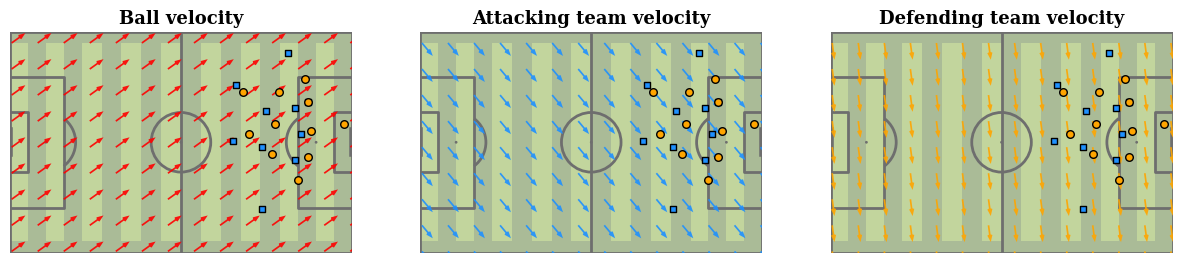

In [5]:
idx, x_chw, t_3 = cache.get(481)
viz = SoccerVisualizer(pitch_length=cache.H, pitch_width=cache.W, layout="x_rows")

fig, axes, arts_list = plot_state_velocity_triptych(
    viz,
    x_chw,
    cache.channels,
    step=8,
    plain=False,
)

# Legend: add only once (e.g., middle axis) and force it above quivers
"""legend = axes[1].legend(
    loc="upper center",
    frameon=True,
    facecolor="#aabb97",
    edgecolor="lightgray",
    fontsize=5,
    labelspacing=0.8,
    borderpad=0.8,
    handletextpad=0.8,
)
legend.get_frame().set_boxstyle("round,pad=0.4")
legend.get_frame().set_alpha(0.95)
legend.set_zorder(1000)
legend.get_frame().set_zorder(1000)"""

plt.show()


In [6]:
import matplotlib.pyplot as plt

def make_pitch_and_cbar_axes(ncols=1, *, figsize=(6, 4), cbar=True, cbar_width=0.05, wspace=0.05):
    """
    Returns (fig, ax, cax) if ncols==1.
    If ncols>1, returns (fig, axes, caxes) where caxes may be None if cbar=False.

    Ensures the main pitch axes have consistent size by reserving a fixed colorbar column.
    """
    if cbar:
        fig = plt.figure(figsize=figsize, constrained_layout=False)
        gs = fig.add_gridspec(1, ncols * 2, width_ratios=[1, cbar_width] * ncols, wspace=wspace)
        axes = []
        caxes = []
        for i in range(ncols):
            axes.append(fig.add_subplot(gs[0, 2*i]))
            caxes.append(fig.add_subplot(gs[0, 2*i + 1]))
        if ncols == 1:
            return fig, axes[0], caxes[0]
        return fig, axes, caxes
    else:
        fig, axes = plt.subplots(1, ncols, figsize=figsize)
        if ncols == 1:
            return fig, axes, None
        return fig, list(axes), None


In [7]:
import torch

def _ch_lookup(x_chw: torch.Tensor, channels: list[str]):
    if not torch.is_tensor(x_chw):
        x_chw = torch.as_tensor(x_chw)
    if x_chw.dim() != 3:
        raise ValueError(f"x_chw must be (C,H,W), got {tuple(x_chw.shape)}")
    if len(channels) != x_chw.shape[0]:
        raise ValueError(f"len(channels)={len(channels)} must match C={x_chw.shape[0]}")
    name_to_idx = {n: i for i, n in enumerate(channels)}

    def ch(name: str) -> torch.Tensor:
        if name not in name_to_idx:
            raise KeyError(f"Channel '{name}' not found. Available: {channels}")
        return x_chw[name_to_idx[name]]

    return ch


def plot_nearest_defender_dist_map(
    viz,
    x_chw: torch.Tensor,        # (C,H,W)
    channels: list[str],
    *,
    ax=None,
    plain: bool = False,
    pitch_kwargs=None,
    cmap=None,                 # passed through to add_heatmap
    add_colorbar: bool = True,
    colorbar_kwargs=None,
    in_pos_kwargs=None,
    out_pos_kwargs=None,
    # layout control (fixes “different sized figure” issue)
    cax=None,                  # if provided, colorbar is drawn here (recommended for consistent sizing)
):
    """
    Plot nearest_def_dist_norm heatmap + players on the same pitch.

    IMPORTANT FOR CONSISTENT SIZING:
      - This function will NOT create a side colorbar axes (which can change layout).
      - If you want a colorbar, pass in `cax=` (pre-created axes) and we draw it there.
      - No titles are ever set.
    """
    ch = _ch_lookup(x_chw, channels)
    atk = ch("atk_team_1hot")
    deff = ch("def_team_1hot")
    nd = ch("nearest_def_dist_norm")

    pitch, fig, ax = viz._build_pitch(ax=ax, plain=plain, pitch_kwargs=pitch_kwargs)
    artists = {}

    # Heatmap under (no internal colorbar axis!)
    hm_out = viz.add_heatmap(
        pitch, fig, ax, nd,
        add_colorbar=False,                 # <-- critical
        edgecolors="none",
    )
    artists.update(hm_out)

    # Optional external colorbar (does not affect pitch axis sizing)
    if add_colorbar and (cax is not None):
        cb = fig.colorbar(hm_out["heatmap"], cax=cax, **(colorbar_kwargs or {}))
        artists["colorbar"] = cb
    else:
        artists["colorbar"] = None

    # Players on top
    artists.update(viz.add_players(
        pitch, ax, atk, deff,
        in_pos_kwargs=in_pos_kwargs,
        out_pos_kwargs=out_pos_kwargs,
    ))

    return fig, ax, artists


def plot_gaussian_control_map(
    viz,
    x_chw: torch.Tensor,        # (C,H,W)
    channels: list[str],
    *,
    ax=None,
    plain: bool = False,
    pitch_kwargs=None,
    cmap=None,                 # passed through to add_heatmap
    add_colorbar: bool = True,
    colorbar_kwargs=None,
    in_pos_kwargs=None,
    out_pos_kwargs=None,
    # layout control (fixes “different sized figure” issue)
    cax=None,                  # if provided, colorbar is drawn here (recommended for consistent sizing)
):
    """
    Plot gaussian_control heatmap + players on the same pitch.

    IMPORTANT FOR CONSISTENT SIZING:
      - This function will NOT create a side colorbar axes (which can change layout).
      - If you want a colorbar, pass in `cax=` (pre-created axes) and we draw it there.
      - No titles are ever set.
    """
    ch = _ch_lookup(x_chw, channels)
    atk = ch("atk_team_1hot")
    deff = ch("def_team_1hot")
    gctl = ch("gaussian_control")

    pitch, fig, ax = viz._build_pitch(ax=ax, plain=plain, pitch_kwargs=pitch_kwargs)
    artists = {}

    # Heatmap under (no internal colorbar axis!)
    hm_out = viz.add_heatmap(
        pitch, fig, ax, gctl,
        add_colorbar=False,                 # <-- critical
        edgecolors="none",
    )
    artists.update(hm_out)

    # Optional external colorbar (does not affect pitch axis sizing)
    if add_colorbar and (cax is not None):
        cb = fig.colorbar(hm_out["heatmap"], cax=cax, **(colorbar_kwargs or {}))
        artists["colorbar"] = cb
    else:
        artists["colorbar"] = None

    # Players on top
    artists.update(viz.add_players(
        pitch, ax, atk, deff,
        in_pos_kwargs=in_pos_kwargs,
        out_pos_kwargs=out_pos_kwargs,
    ))

    return fig, ax, artists


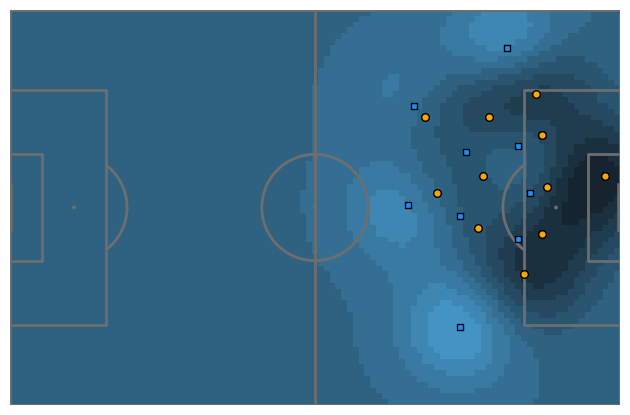

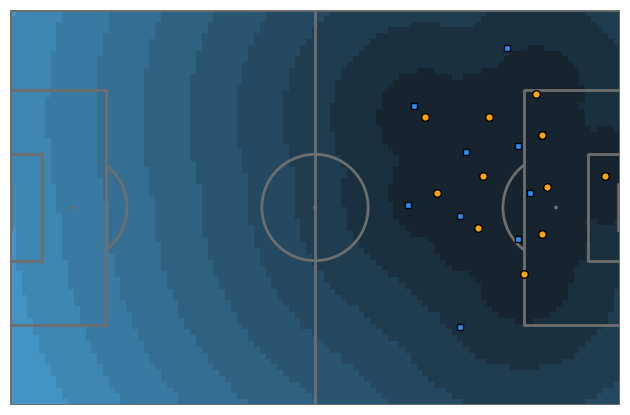

In [8]:
fig, ax, arts = plot_gaussian_control_map(viz, x_chw, cache.channels, add_colorbar=True)
fig, ax, arts = plot_nearest_defender_dist_map(viz, x_chw, cache.channels, add_colorbar=False)


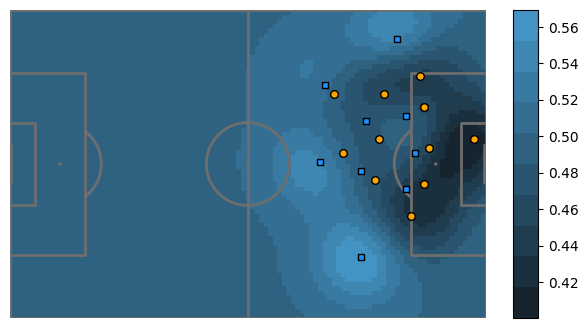

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax  = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])

plot_gaussian_control_map(viz, x_chw, cache.channels, ax=ax, cax=cax, add_colorbar=True)

plt.show()


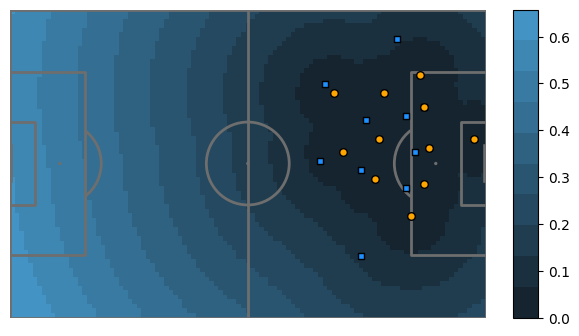

In [10]:
fig = plt.figure(figsize=(7, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
ax  = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])
plot_nearest_defender_dist_map(viz, x_chw, cache.channels, ax=ax, cax=cax, add_colorbar=True)

plt.show()